导入需要的包

In [1]:
!git clone https://github.com/qianjindexiaozu/Pest-Identification.git

Cloning into 'Pest-Identification'...
remote: Enumerating objects: 644, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 644 (delta 10), reused 28 (delta 8), pack-reused 614 (from 1)
Receiving objects: 100% (644/644), 163.62 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (2808/2808), done.


In [2]:
from torch.utils.data import DataLoader # 用于构建数据加载器
from torchvision import transforms      # 用于将数据图片格式化
from torch.utils.tensorboard import SummaryWriter   # 用于展示处理过程
import sys
import os
import json
import tqdm
import torch.optim as optim
from tqdm import tqdm

创建数据集

In [3]:
import torchvision

# aphids 蚜虫
# armyWorm 粘虫
# beetle 甲虫
# bollWorm 棉铃虫
# grasshopper 蚱蜢
# mites 螨虫
# sawfly 叶蜂
# stemBorer 茎蚜虫

def remove_non_three_channels(image):
    """移除非三通道的图像"""
    if image.shape[0] != 3:
        return None
    else:
        return image

tranform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(remove_non_three_channels),
])

# 训练数据
root_dir = 'Pest-Identification/dataset/train'
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=tranform)

# 过滤掉None值
train_dataset = [item for item in train_dataset if item[1] is not None]

# 测试数据
root_dir = 'Pest-Identification/dataset/test'

tranform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(remove_non_three_channels),
])

test_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=tranform)

# 过滤掉None值
test_dataset = [item for item in test_dataset if item[1] is not None]


In [4]:
# length长度
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)

batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
print("using {} images for training, {} images for validation.".format(train_data_size, test_data_size))

# 利用DataLoader加载数据集
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=nw)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=nw)

Using 2 dataloader workers every process
using 2400 images for training, 400 images for validation.


In [5]:
# 添加模型
import torch.nn as nn
import torch

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

net = resnet34()
 # load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "Pest-Identification/resnet34.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 8) # 8个类别
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 10
best_acc = 0.0
save_path = 'Pest-Identification/resNet34-after.pth'
train_steps = len(train_dataloader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_dataloader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(test_dataloader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            # loss = loss_function(outputs, test_labels)
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                        epochs)

    val_accurate = acc / test_data_size
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.


<ipython-input-6-98fb22bdcd90>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))


valid epoch[1/10]: 100%|██████████| 25/25 [00:01<00:00, 22.85it/s]
[epoch 1] train_loss: 0.798  val_accuracy: 0.953
valid epoch[2/10]: 100%|██████████| 25/25 [00:00<00:00, 26.62it/s]
[epoch 2] train_loss: 0.164  val_accuracy: 0.955
valid epoch[3/10]: 100%|██████████| 25/25 [00:00<00:00, 26.55it/s]
[epoch 3] train_loss: 0.095  val_accuracy: 0.970
valid epoch[4/10]: 100%|██████████| 25/25 [00:00<00:00, 26.77it/s]
[epoch 4] train_loss: 0.085  val_accuracy: 0.955
valid epoch[5/10]: 100%|██████████| 25/25 [00:00<00:00, 26.37it/s]
[epoch 5] train_loss: 0.098  val_accuracy: 0.953
valid epoch[6/10]: 100%|██████████| 25/25 [00:01<00:00, 23.69it/s]
[epoch 6] train_loss: 0.094  val_accuracy: 0.973
valid epoch[7/10]: 100%|██████████| 25/25 [00:01<00:00, 23.27it/s]
[epoch 7] train_loss: 0.061  val_accuracy: 0.960
valid epoch[8/10]: 100%|██████████| 25/25 [00:00<00:00, 26.28it/s]
[epoch 8] train_loss: 0.062  val_accuracy: 0.955
valid epoch[9/10]: 100%|██████████| 25/25 [00:00<00:00, 26.15it/s]
[epoc

<ipython-input-7-ccfbd3f22a21>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


class: aphids       prob: 0.00221
class: armyWorm     prob: 0.00026
class: beetle       prob: 0.000294
class: bollWorm     prob: 0.00058
class: grasshopper   prob: 0.997
class: mites        prob: 6.19e-05
class: sawfly       prob: 1.17e-05
class: stemBorer    prob: 6.66e-05


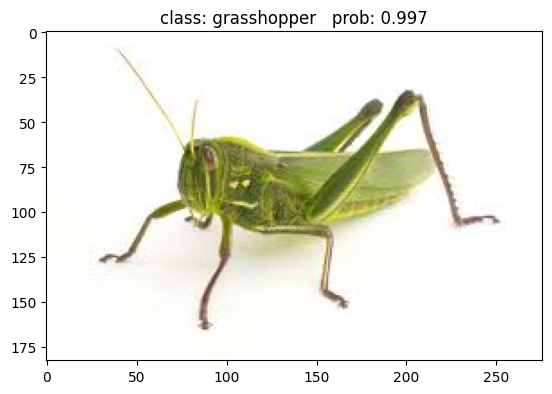

In [7]:
# 测试
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# load image
img_path = "Pest-Identification/images.jpeg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = 'Pest-Identification/class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = resnet34(num_classes=8).to(device)

# load model weights
weights_path = "Pest-Identification/resNet34-after.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

# prediction
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                              predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()